In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0117.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0101.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0108.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0110.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0119.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0115.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0116.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0105.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0106.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0121.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0111.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0103.jpeg
/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Normal/0120.jpeg
/kaggle/input/covid19-image-dataset/Co

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
import time
import random 
import shutil
from skimage import io, transform
import math
import torch
import pandas as pd
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.utils import make_grid
import helper
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


print("using Pytorch version", torch.__version__)



using Pytorch version 1.9.1


In [8]:
class_names = ['Normal', 'Viral Pneumonia', 'Covid']
data_dir = '../input/covid19-image-dataset/Covid19-dataset'


In [9]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
train_ds = ImageFolder(data_dir+'/train', train_transform)
test_ds = ImageFolder(data_dir+'/test', test_transform)
classes = train_ds.classes

Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 251
Counts: {'Covid': 111, 'Normal': 70, 'Viral Pneumonia': 70}


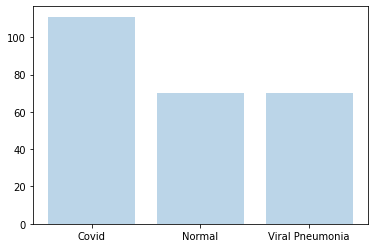

In [11]:
def describe_dataset(data):
    classes_count = { c:0 for c in classes}
    for _,label in data:
        classes_count[classes[label]]+=1

    print(f'Classes: {len(classes)} - {classes} ')
    print(f'Examples: {len(data)}')
    print(f'Counts: {classes_count}')
    plt.bar(classes_count.keys(),classes_count.values(), alpha=0.3 )

    return classes_count

_ = describe_dataset(train_ds)


TRAIN DATASET
Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 221
Counts: {'Covid': 97, 'Normal': 65, 'Viral Pneumonia': 59}

VALIDATION DATASET
Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 30
Counts: {'Covid': 14, 'Normal': 5, 'Viral Pneumonia': 11}

TEST DATASET
Classes: 3 - ['Covid', 'Normal', 'Viral Pneumonia'] 
Examples: 66
Counts: {'Covid': 26, 'Normal': 20, 'Viral Pneumonia': 20}


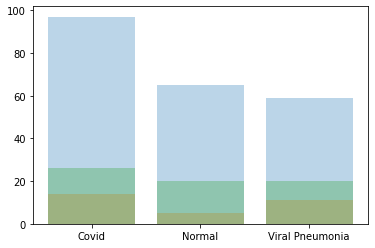

In [12]:
from torch.utils.data import random_split
random_seed = 42
torch.manual_seed(random_seed);

val_size = 30
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])

print("\nTRAIN DATASET")
_=describe_dataset(train_ds)

print("\nVALIDATION DATASET")
_=describe_dataset(val_ds)

print("\nTEST DATASET")
_=describe_dataset(test_ds)

dataset = None
new_dataset = None

In [13]:
batch_size = 5

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(train_loader))
print('Number of validation batches', len(valid_loader))
print('Number of test batches', len(test_loader))

Number of training batches 45
Number of validation batches 6
Number of test batches 14


In [14]:
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{classes[int(labels[i].numpy())]}')
        plt.ylabel(f'{classes[int(preds[i].numpy())]}', color=col)
        if(i==5):
            break
    plt.tight_layout()
    plt.show()

In [15]:
images, labels = next(iter(train_loader))

In [16]:
images.shape

torch.Size([5, 3, 224, 224])

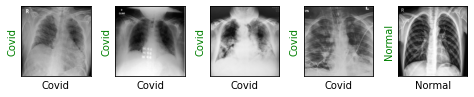

In [17]:
show_images(images, labels, labels) 

In [18]:
print(train_ds[0][0].shape)
train_ds[0]

torch.Size([3, 224, 224])


(tensor([[[-1.8268, -1.8097, -1.8097,  ..., -1.7069, -1.6898, -1.7069],
          [-1.8439, -1.8268, -1.8268,  ..., -1.6898, -1.6898, -1.7240],
          [-1.8439, -1.8439, -1.8268,  ..., -1.6898, -1.6898, -1.7069],
          ...,
          [-1.7583, -1.7240, -1.7240,  ..., -1.8782, -1.8610, -1.8610],
          [-1.7754, -1.7240, -1.7240,  ..., -1.8610, -1.8782, -1.8782],
          [-1.7412, -1.7240, -1.7240,  ..., -1.8610, -1.8782, -1.8782]],
 
         [[-1.7381, -1.7206, -1.7206,  ..., -1.6155, -1.5980, -1.6155],
          [-1.7556, -1.7381, -1.7381,  ..., -1.5980, -1.5980, -1.6331],
          [-1.7556, -1.7556, -1.7381,  ..., -1.5980, -1.5980, -1.6155],
          ...,
          [-1.6681, -1.6331, -1.6331,  ..., -1.7906, -1.7731, -1.7731],
          [-1.6856, -1.6331, -1.6331,  ..., -1.7731, -1.7906, -1.7906],
          [-1.6506, -1.6331, -1.6331,  ..., -1.7731, -1.7906, -1.7906]],
 
         [[-1.5081, -1.4907, -1.4907,  ..., -1.3861, -1.3687, -1.3861],
          [-1.5256, -1.5081,

In [19]:
def show_example(img, label):
    print('Label: ', classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Normal (1)


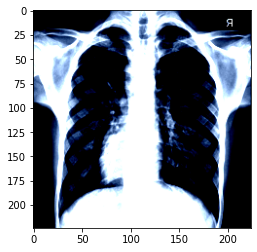

In [20]:
show_example(*train_ds[0])

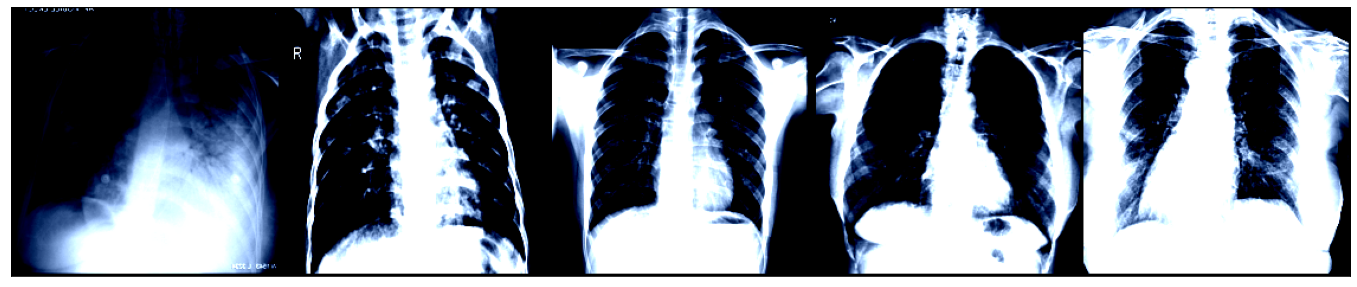

In [21]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(24, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

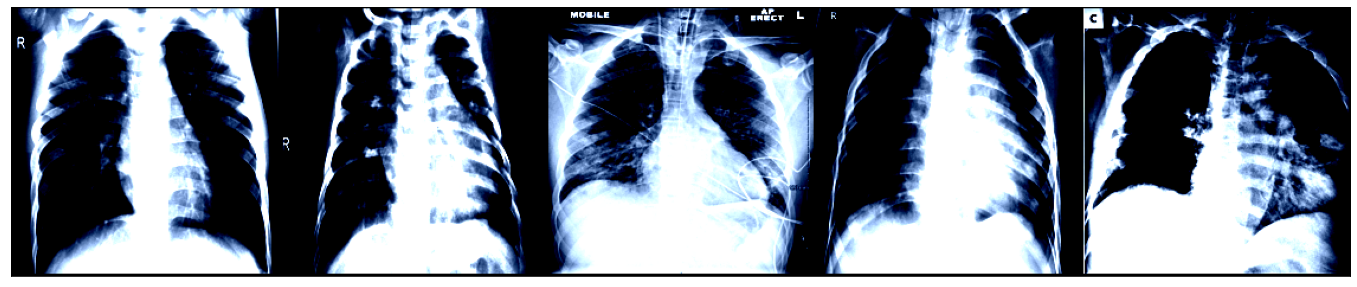

In [22]:
show_batch(test_loader)

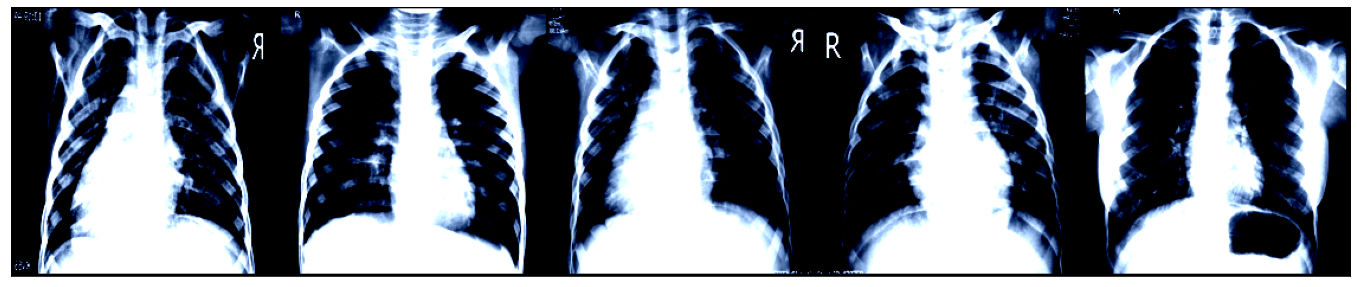

In [23]:
show_batch(valid_loader)

In [24]:
def change_device(input):
    if torch.cuda.is_available():
        return input.cuda()
    else:
        return input

In [25]:
def train(model, train_loader):
    
    model.train()
    
    epoch_loss = 0

    for train_step, (images, labels) in enumerate(train_loader):

        x_train = change_device(images)
        y_train = change_device(labels)

        optimizer.zero_grad()
        
        y_pred = model(x_train)
        
        loss = loss_fn(y_pred,y_train)
        
        loss.backward()
        
        optimizer.step()

        if(train_step%20==0):
            print(f"batch:   {train_step}   train_loss   {loss.item()}   perplexity   = {torch.exp(loss)}")
        
        epoch_loss += loss.item()
        
    return epoch_loss / (train_step +1 )



In [26]:
def evaluate(model, loader):
    
    model.eval()
    print("validation/test set evaluation")
    epoch_loss = 0
    
    with torch.no_grad():
        accuracy = 0
        for val_step, (images, labels) in enumerate(loader):
            x_train = change_device(images)
            y_train = change_device(labels)

            y_pred = model(x_train)

            loss = loss_fn(y_pred,y_train)

            _, preds = torch.max(y_pred, 1)
            accuracy += sum(( preds.cpu() == labels).numpy())

            if(val_step%3==0):
                print(f"batch:   {val_step}   validation_loss   {loss.item()}   perplexity   = {torch.exp(loss)}")
        
            epoch_loss += loss.item()
        accuracy = accuracy/len(val_ds)
        print(f' Accuracy: {accuracy:.4f}')

    return epoch_loss / (val_step + 1)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
def show_preds(model,loader):
    model.eval() 
    print("test set evaluation")

    with torch.no_grad():
        accuracy = 0
        for test_step, (images, labels) in enumerate(loader):
            x_train = change_device(images)
            y_train = change_device(labels)

            y_pred = model(x_train)

            loss = loss_fn(y_pred,y_train)

            _, preds = torch.max(y_pred, 1)
          
            accuracy += sum(( preds.cpu() == labels).numpy())
        accuracy = accuracy/len(test_ds)
        print(f' Accuracy: {accuracy:.4f}')

    show_images(images, labels, preds.cpu())

In [29]:
class VGGNet(nn.Module):
    def __init__ (self):
        super(VGGNet,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1,stride=1) #224
        self.maxPool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,stride=1) #112
        self.maxPool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,stride=1) #56
        self.maxPool3 = nn.MaxPool2d(2,2)

        self.conv4 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1,stride=1) #28
        self.maxPool4 = nn.MaxPool2d(2,2)

        self.conv5 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=1,padding=0,stride=1)
        self.maxPool5 = nn.MaxPool2d(2,2)

        self.conv6 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1) #14
        self.maxPool6 = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(4608,1024) #7
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,3)

    def forward(self , x):
               
        x = self.maxPool1(F.relu(self.conv1(x)))

        x = self.maxPool2(F.relu(self.conv2(x)))

        x = self.maxPool3(F.relu(self.conv3(x)))

        x = self.maxPool4(F.relu(self.conv4(x)))

        x = self.maxPool5(F.relu(self.conv5(x)))

        x = self.maxPool6(F.relu(self.conv6(x)))

        x = x.reshape(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return x

In [30]:
model = change_device(VGGNet())

In [31]:
for param in model.parameters():
    print(f' {param.size()} parameters are {param.numel()}')

 torch.Size([64, 3, 3, 3]) parameters are 1728
 torch.Size([64]) parameters are 64
 torch.Size([128, 64, 3, 3]) parameters are 73728
 torch.Size([128]) parameters are 128
 torch.Size([256, 128, 3, 3]) parameters are 294912
 torch.Size([256]) parameters are 256
 torch.Size([512, 256, 3, 3]) parameters are 1179648
 torch.Size([512]) parameters are 512
 torch.Size([512, 512, 1, 1]) parameters are 262144
 torch.Size([512]) parameters are 512
 torch.Size([512, 512, 3, 3]) parameters are 2359296
 torch.Size([512]) parameters are 512
 torch.Size([1024, 4608]) parameters are 4718592
 torch.Size([1024]) parameters are 1024
 torch.Size([512, 1024]) parameters are 524288
 torch.Size([512]) parameters are 512
 torch.Size([3, 512]) parameters are 1536
 torch.Size([3]) parameters are 3


In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')


The model has 9,419,395 trainable parameters and total memory usage is 107.79642105102539 mb


In [33]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [34]:
N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_2.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')



batch:   0   train_loss   1.0903400182724   perplexity   = 2.975285530090332
batch:   20   train_loss   1.1112526655197144   perplexity   = 3.0381617546081543
batch:   40   train_loss   1.0572099685668945   perplexity   = 2.878329038619995
validation/test set evaluation
batch:   0   validation_loss   1.0216853618621826   perplexity   = 2.7778725624084473
batch:   3   validation_loss   1.0483405590057373   perplexity   = 2.8529129028320312
 Accuracy: 0.7000
saving the model
Epoch: 01 | Time: 0m 17s
	Train Loss: 1.089 | Train PPL:   2.971
	 Val. Loss: 1.044 |  Val. PPL:   2.840
batch:   0   train_loss   1.0399558544158936   perplexity   = 2.829092264175415
batch:   20   train_loss   0.6478679180145264   perplexity   = 1.9114611148834229
batch:   40   train_loss   0.6069024205207825   perplexity   = 1.834739327430725
validation/test set evaluation
batch:   0   validation_loss   0.585426926612854   perplexity   = 1.7957574129104614
batch:   3   validation_loss   0.1891438513994217   perple

test set evaluation
 Accuracy: 0.8939


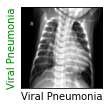

In [35]:
show_preds(model, test_loader) #learning rate 3e-5

### Resnet 18 

In [36]:
class two_layer_Block(nn.Module):
    def __init__(self, num_layers, in_channels,intermediate_channels, identity_downsample=None, stride=1):
        super(two_layer_Block, self).__init__()

        self.num_layers = num_layers
        self.expansion = 1

        self.conv1 = nn.Conv2d(in_channels,intermediate_channels,kernel_size=3, padding = 1, stride=1)

        self.bn1 = nn.BatchNorm2d(intermediate_channels)

        self.conv2 = nn.Conv2d(intermediate_channels,intermediate_channels,kernel_size=3, padding=1, stride= stride)

        self.bn2 = nn.BatchNorm2d(intermediate_channels)

        self.relu = nn.ReLU()

        self.identity_downsample = identity_downsample
      
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

class three_layer_Block(nn.Module):
    def __init__(self, num_layers, in_channels,intermediate_channels, identity_downsample=None, stride=1):
        super(three_layer_Block, self).__init__()
        self.num_layers = num_layers
        self.expansion = 4

        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0)

        self.bn1 = nn.BatchNorm2d(intermediate_channels)

        self.conv2 = nn.Conv2d(intermediate_channels,intermediate_channels,kernel_size=3,stride=stride,padding=1)

        self.bn2 = nn.BatchNorm2d(intermediate_channels)

        self.conv3 = nn.Conv2d(intermediate_channels,intermediate_channels * self.expansion,kernel_size=1,stride=1,padding=0)

        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)

        self.relu = nn.ReLU()

        self.identity_downsample = identity_downsample

        self.stride = stride
      
    def forward(self, x):

        identity = x.clone()
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self,  num_layers, Block, img_channels, num_classes):
        super(ResNet, self).__init__()
        self.expansion = 4

        if ( num_layers< 50):
            self.expansion = 1

        if (num_layers==18):
            layers = [2,2,2,2]
      
        elif (num_layers==34):
            layers = [3,4,6,3]
        
        elif (num_layers == 50):
            layers = [3,4,6,3]
        elif (num_layers==101):
            layers = [3,4,23,3]
        elif (num_layers==152):
            layers = [3,8,36,3]

        print(layers)
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=64, kernel_size=7, padding=3, stride=2)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.layer1 = self.make_layer(num_layers, Block, layers[0],intermediate_channels = 64,stride=1)
        self.layer2 = self.make_layer(num_layers, Block, layers[1],intermediate_channels = 128,stride=2)
        self.layer3 = self.make_layer(num_layers, Block, layers[2],intermediate_channels = 256,stride=2)
        self.layer4 = self.make_layer(num_layers, Block, layers[3],intermediate_channels = 512,stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512*self.expansion, num_classes)

    def forward(self, x):

        x = self.relu(self.bn(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layer(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []
        identity_downsample = None
        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                                      nn.BatchNorm2d(intermediate_channels*self.expansion))


        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion 

        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) 

        return nn.Sequential(*layers)

def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18,two_layer_Block, img_channels, num_classes)


def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, two_layer_Block, img_channels, num_classes)


def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, three_layer_Block, img_channels, num_classes)


def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101,  three_layer_Block, img_channels, num_classes)


def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152,  three_layer_Block, img_channels, num_classes)



In [37]:
model = change_device(ResNet18(3,3))


[2, 2, 2, 2]


In [38]:
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): two_layer_Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): two_layer_Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa

In [39]:
for param in model.parameters():
    print(f' {param.size()} parameters are {param.numel()}')



 torch.Size([64, 3, 7, 7]) parameters are 9408
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 3, 3]) parameters are 36864
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 3, 3]) parameters are 36864
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 1, 1]) parameters are 4096
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 3, 3]) parameters are 36864
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 3, 3]) parameters are 36864
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([128, 64, 3, 3]) parameters are 73728
 torch.Size

In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')

The model has 11,187,139 trainable parameters and total memory usage is 128.0266456604004 mb


In [41]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)


In [42]:
N_EPOCHS = 15

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_resnet.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


batch:   0   train_loss   1.1234418153762817   perplexity   = 3.075421094894409
batch:   20   train_loss   0.8982836008071899   perplexity   = 2.4553849697113037
batch:   40   train_loss   0.45597854256629944   perplexity   = 1.577716588973999
validation/test set evaluation
batch:   0   validation_loss   0.7244609594345093   perplexity   = 2.0636184215545654
batch:   3   validation_loss   0.6420755982398987   perplexity   = 1.9004212617874146
 Accuracy: 0.8333
saving the model
Epoch: 01 | Time: 0m 12s
	Train Loss: 0.696 | Train PPL:   2.006
	 Val. Loss: 0.321 |  Val. PPL:   1.379
batch:   0   train_loss   0.4137495458126068   perplexity   = 1.512478232383728
batch:   20   train_loss   0.4183719754219055   perplexity   = 1.5194857120513916
batch:   40   train_loss   0.10815886408090591   perplexity   = 1.1142247915267944
validation/test set evaluation
batch:   0   validation_loss   0.15476547181606293   perplexity   = 1.167384147644043
batch:   3   validation_loss   1.6436586380004883  

test set evaluation
 Accuracy: 0.8636


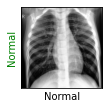

In [43]:
show_preds(model, test_loader) # using learning rate 3e-5

Resnet 18 pretrained using imagenet weights

In [44]:
resnet18 = torchvision.models.resnet18(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [45]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

In [69]:
model = resnet18.cuda()

In [70]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')


The model has 11,178,051 trainable parameters and total memory usage is 127.92264175415039 mb


In [71]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [72]:
N_EPOCHS = 8

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_resnet_pretrained.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   0.0030293739400804043   perplexity   = 1.003033995628357
batch:   20   train_loss   0.0060590640641748905   perplexity   = 1.006077527999878
batch:   40   train_loss   0.003982422407716513   perplexity   = 1.0039904117584229
validation/test set evaluation
batch:   0   validation_loss   0.005608152132481337   perplexity   = 1.0056239366531372
batch:   3   validation_loss   0.00011655108392005786   perplexity   = 1.0001165866851807
 Accuracy: 1.0000
saving the model
Epoch: 01 | Time: 0m 11s
	Train Loss: 0.102 | Train PPL:   1.107
	 Val. Loss: 0.005 |  Val. PPL:   1.005
batch:   0   train_loss   0.0016040194313973188   perplexity   = 1.0016053915023804
batch:   20   train_loss   0.008920224383473396   perplexity   = 1.0089601278305054
batch:   40   train_loss   0.008215346373617649   perplexity   = 1.0082491636276245
validation/test set evaluation
batch:   0   validation_loss   0.013033045455813408   perplexity   = 1.0131182670593262
batch:   3   validation_loss 

test set evaluation
 Accuracy: 1.0000


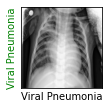

In [50]:
show_preds(model, test_loader)

### DesnseNet self implementation

In [51]:
class DenseNet(nn.Module):
    def __init__(self, img_channels, num_classes, num_init_features, growth_factor,layers):
        super(DenseNet,self).__init__()

        self.growth_factor = growth_factor

        self.conv1 = nn.Conv2d(in_channels=img_channels,out_channels=num_init_features,kernel_size=7,padding=3,stride=2)

        self.bn = nn.BatchNorm2d(num_init_features)

        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.denselayer1 = self.make_layer(DenseBlock,num_init_features, layers[0])

        self.transitionlayer1 = TransitionBlock(num_init_features + self.growth_factor*layers[0])

        self.denselayer2 = self.make_layer(DenseBlock,int((num_init_features + growth_factor*layers[0])/2), layers[1])

        self.transitionlayer2 = TransitionBlock(int((num_init_features + self.growth_factor*layers[0])/2 + self.growth_factor*layers[1]))

        self.denselayer3 = self.make_layer(DenseBlock,int(((num_init_features + self.growth_factor*layers[0])/2 + self.growth_factor*layers[1])/2), layers[2])

        self.transitionlayer3 = TransitionBlock(int(((num_init_features + self.growth_factor*layers[0])/2 + self.growth_factor*layers[1])/2) + self.growth_factor*layers[2])

        self.denselayer4 = self.make_layer(DenseBlock,int((((num_init_features + self.growth_factor*layers[0])/2 + self.growth_factor*layers[1])/2 + self.growth_factor*layers[2])/2), 
                                      layers[3])

        self.averagepool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(int(num_init_features/8 + self.growth_factor*(layers[0]/8 + layers[1]/4 + layers[2]/2 + layers[3])),num_classes) #we only need to chage the output features while pre training

    def forward(self, x):
        x = self.relu(self.bn(self.conv1(x)))
        x = self.maxpool(x)
        x = self.denselayer1(x)
        x = self.transitionlayer1(x)
        x = self.denselayer2(x)
        x = self.transitionlayer2(x)
        x = self.denselayer3(x)
        x = self.transitionlayer3(x)
        x = self.denselayer4(x)
        x = self.averagepool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def make_layer(self, DenseBlock, features, layer):
        dense_block = []
        for i in range(layer):
            dense_block.append(DenseBlock(features + i*32,self.growth_factor))

        return nn.Sequential(*dense_block)

class DenseBlock(nn.Module):
    def __init__ (self,input_features, growth_factor):
        super(DenseBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(input_features)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=input_features,out_channels=4*growth_factor,kernel_size=1,stride=1)
        self.bn2 = nn.BatchNorm2d(4*growth_factor)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=4*growth_factor,out_channels=growth_factor,kernel_size=3,stride=1,padding=1)

    def forward(self, x):
        concat_layer = x.clone()
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv2(x)

        return torch.cat((concat_layer, x), dim=1)



class TransitionBlock(nn.Module):
    def __init__(self, input_features):
        super(TransitionBlock,self).__init__()
        self.bn = nn.BatchNorm2d(input_features)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=input_features,out_channels=int(input_features/2),kernel_size=1,stride=1,padding=0)
        self.avpool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.avpool(x)

        return x




def DenseNet121(img_channels=3, num_classes=1000,num_init_features=64,growth_factor=32):
    return DenseNet(img_channels,num_classes, num_init_features, growth_factor,[6, 12, 24, 16])

def DenseNet161(img_channels=3, num_classes=1000,num_init_features=96,growth_factor=48):
    return DenseNet(img_channels,num_classes, num_init_features, growth_factor,[6, 12, 36, 24])

def DenseNet169(img_channels=3, num_classes=1000,num_init_features=64,growth_factor=32):
    return DenseNet(img_channels,num_classes, num_init_features, growth_factor,[6, 12, 32, 32])

def DenseNet201(img_channels=3, num_classes=1000,num_init_features=64,growth_factor=32):
    return DenseNet(img_channels,num_classes, num_init_features, growth_factor,[6, 12, 48, 32])

def DenseNet264(img_channels=3, num_classes=1000,num_init_features=64,growth_factor=32):
    return DenseNet(img_channels,num_classes, num_init_features, growth_factor,[6, 12, 64, 48])

In [52]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
for param in model.parameters():
    print(f' {param.size()} parameters are {param.numel()}')

 torch.Size([64, 3, 7, 7]) parameters are 9408
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 3, 3]) parameters are 36864
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 3, 3]) parameters are 36864
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 3, 3]) parameters are 36864
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64, 64, 3, 3]) parameters are 36864
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([128, 64, 3, 3]) parameters are 73728
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([128, 128, 3, 3]) parameters are 147456
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([128, 64, 1, 1]) parameters are 8192
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([128, 

In [54]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')


The model has 11,178,051 trainable parameters and total memory usage is 127.92264175415039 mb


In [55]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [56]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_densenet.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   0.02089686691761017   perplexity   = 1.0211167335510254
batch:   20   train_loss   1.1750664710998535   perplexity   = 3.23835825920105
batch:   40   train_loss   0.10270700603723526   perplexity   = 1.1081666946411133
validation/test set evaluation
batch:   0   validation_loss   0.02433287352323532   perplexity   = 1.024631381034851
batch:   3   validation_loss   0.01653778925538063   perplexity   = 1.0166752338409424
 Accuracy: 1.0000
saving the model
Epoch: 01 | Time: 0m 11s
	Train Loss: 0.073 | Train PPL:   1.075
	 Val. Loss: 0.010 |  Val. PPL:   1.010
batch:   0   train_loss   0.001670860918238759   perplexity   = 1.0016722679138184
batch:   20   train_loss   0.010629592463374138   perplexity   = 1.0106862783432007
batch:   40   train_loss   0.004534975625574589   perplexity   = 1.0045453310012817
validation/test set evaluation
batch:   0   validation_loss   0.006771157030016184   perplexity   = 1.0067940950393677
batch:   3   validation_loss   0.00285486

test set evaluation
 Accuracy: 0.9848


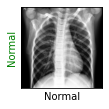

In [57]:
show_preds(model, test_loader)

## Densenet pretrained 

In [58]:
densenet121 = torchvision.models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [59]:
class DenseNet(nn.Module):
    def __init__(self, model):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.averagepool = nn.AdaptiveAvgPool2d(1)
        
        # get the classifier of the vgg19
        self.classifier = torch.nn.Linear(in_features=1024, out_features=3)
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        if x.requires_grad:
            h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.averagepool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [60]:
model = change_device(DenseNet(densenet121))

In [61]:
for param in model.parameters():
    print(f' {param.size()} parameters are {param.numel()}')


 torch.Size([64, 3, 7, 7]) parameters are 9408
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([64]) parameters are 64
 torch.Size([128, 64, 1, 1]) parameters are 8192
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([32, 128, 3, 3]) parameters are 36864
 torch.Size([96]) parameters are 96
 torch.Size([96]) parameters are 96
 torch.Size([128, 96, 1, 1]) parameters are 12288
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([32, 128, 3, 3]) parameters are 36864
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([128, 128, 1, 1]) parameters are 16384
 torch.Size([128]) parameters are 128
 torch.Size([128]) parameters are 128
 torch.Size([32, 128, 3, 3]) parameters are 36864
 torch.Size([160]) parameters are 160
 torch.Size([160]) parameters are 160
 torch.Size([128, 160, 1, 1]) parameters are 20480
 torch

In [62]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')

The model has 7,981,931 trainable parameters and total memory usage is 91.34595108032227 mb


In [63]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [64]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader)
    valid_loss = evaluate(model, valid_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        print("saving the model")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_1_densenet_pretrained_cam.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

batch:   0   train_loss   1.0560780763626099   perplexity   = 2.875073194503784
batch:   20   train_loss   0.8510165214538574   perplexity   = 2.3420262336730957
batch:   40   train_loss   0.5860862135887146   perplexity   = 1.7969417572021484
validation/test set evaluation
batch:   0   validation_loss   0.233271986246109   perplexity   = 1.2627248764038086
batch:   3   validation_loss   0.22463269531726837   perplexity   = 1.2518627643585205
 Accuracy: 0.9333
saving the model
Epoch: 01 | Time: 0m 14s
	Train Loss: 0.691 | Train PPL:   1.995
	 Val. Loss: 0.268 |  Val. PPL:   1.307
batch:   0   train_loss   0.19406422972679138   perplexity   = 1.2141742706298828
batch:   20   train_loss   0.1969529688358307   perplexity   = 1.2176867723464966
batch:   40   train_loss   0.15116555988788605   perplexity   = 1.163189172744751
validation/test set evaluation
batch:   0   validation_loss   0.06056296080350876   perplexity   = 1.0624345541000366
batch:   3   validation_loss   0.1930770128965377

test set evaluation
 Accuracy: 1.0000


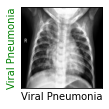

In [65]:
show_preds(model, test_loader)

In [66]:
import plotly.figure_factory as ff

data_matrix = [['Classes','Data_available'],
               ['Normal', 70],
               ['Viral_Pneumonia', 70],
               ['Covid', 111]]

colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]

fig = ff.create_table(data_matrix,colorscale=colorscale)
fig.update_layout(
    title_text = 'Data used for training',
    margin = {'t':40},
    height = 200,
    title_x=0.5
)
fig.show()



In [3]:
import plotly.figure_factory as ff

data_matrix = [['Testing paramter','Self-VGG-16','Vgg16 pretrained','Vgg 19', 'Self-Resnet18','Pre Resnet','Self-Densenet','Pre-trained Densenet'],
               ['Accuracy', 0.8939,0.954, 0.96,0.86, 0.985, 0.9848, 1.000]]

fig = ff.create_table(data_matrix)
fig.show()